In [1]:
import requests
import bs4
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import time

import acquire as a
import McCrosky_Prepare as p
from env import github_token, github_username

### Acquire

#### Acquiring Repo_List

In [2]:
def get_repo_list():
    '''
    This function is designed to create a repo list from the most starred 
    repositories on github.
    
    The function loops through 20 pages with 10 results per page of the most 
    starred repos on github using a range from 1 to 21.
    
    It then uses another loop to pull out all the titles of each repo using 
    the beautiful soup library and html per page.
    '''
    ## setting up authentications
    headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}
    
    ## initializing blank list for appending the repo's pulled
    repo_list = []
    clean_repo_list = []
    
    ## creating a list with a range of 1 to 21 to loop through 20 pages x being the 
    ## page number in the url
    for x in range(1,21):
        response = requests.get(f'https://github.com/search?p={x}&q=stars%3A%3E0&s=stars&type=Repositories', 
                                headers = headers)
        html = response.content
        soup = bs4.BeautifulSoup(html, 'html.parser')
        
        title = soup.find_all(class_= 'v-align-middle') ## <-- where the repo titles lie in html
        time.sleep(15)
        
        ## looping through the string to append a list of repo titles
        for y in title:
            repo_list.append(y.get_text())
        
    ## looping through the repo list again to remove any null elements or white space
    for repo in repo_list:
        if (len(repo)) > 3:
            clean_repo_list.append(repo)     
        
    return clean_repo_list

In [3]:
repos = get_repo_list()

print(f'The length of the repo list is: {len(repos)}\n') ## <-- quality assurance check

repos[:6] ## <-- quality assurance check

The length of the repo list is: 200



['freeCodeCamp/freeCodeCamp',
 '996icu/996.ICU',
 'EbookFoundation/free-programming-books',
 'jwasham/coding-interview-university',
 'vuejs/vue',
 'facebook/react']

#### Acquiring Our DataFrame

In [4]:
df = pd.read_json('data2.json') ## reading our json file into a dataframe after

## running acquire.py from the terminal

df.head()

,repo,language,readme_contents
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...
1,996icu/996.ICU,Rust,[996.ICU](https://996.icu/#/en_US)\n=======\n*...
2,EbookFoundation/free-programming-books,None,This page is available as an easy-to-read webs...
3,jwasham/coding-interview-university,None,# Coding Interview University\n\n> I originall...
4,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ..."


In [5]:
df.shape ## looking at the shape of our dataframe

(198, 3)

#### Filtering down to top Four Languages

In [6]:
top_four = df.language.value_counts().keys()[0:4] ## looking at the top four languages used

In [7]:
top_four

Index(['JavaScript', 'Python', 'Java', 'Go'], dtype='object')

In [8]:
df = df[df.language.isin(top_four)] ## filtering down the data to the top four languages

In [9]:
df.language.value_counts() ## <-- target variable value counts

JavaScript    59
Python        24
Java          16
Go            13
Name: language, dtype: int64

#### Creating Filtered CSV For Team Project WorkFlow

In [10]:
df.to_csv('NLP_df.csv') ## <-- creating csv of dataframe for team project use.

### Prepare

In [12]:
df = p.prep_content_columns(df) ## using our prepare function to build clean column
## stemmed content column & Lemmatized content column

df.head() ## <-- quality assurance check

,repo,language,readme_contents,Clean,Stemmed,Lemmatized
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...,freecodecamporg social bannerhttpss3amazonawsc...
4,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ...",p aligncentera hrefhttpsvuejsorg targetblank r...,p aligncentera hrefhttpsvuejsorg targetblank r...,p aligncentera hrefhttpsvuejsorg targetblank r...
5,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...,reacthttpsreactjsorg middot github licensehttp...,reacthttpsreactjsorg middot github licensehttp...,reacthttpsreactjsorg middot github licensehttp...
9,twbs/bootstrap,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",p aligncenter hrefhttpsgetbootstrapcom img src...,p aligncent hrefhttpsgetbootstrapcom img srcht...,p aligncenter hrefhttpsgetbootstrapcom img src...
10,public-apis/public-apis,Python,# Public APIs [![Run tests](https://github.com...,public apis run testshttpsgithubcompublicapisp...,public api run testshttpsgithubcompublicapispu...,public apis run testshttpsgithubcompublicapisp...


### Explore

In [25]:
df.language.value_counts() ## <-- looking at out different language categories

JavaScript    59
Python        24
Java          16
Go            13
Name: language, dtype: int64

In [27]:
## making strings of all the words used for each category

javascript_words = ' '.join(df[df.language == 'JavaScript'].Clean)
python_words = ' '.join(df[df.language == 'Python'].Clean)
java_words = ' '.join(df[df.language == 'Java'].Clean)
go_words = ' '.join(df[df.language == 'Go'].Clean)
all_words = ' '.join(df.Clean)

In [28]:
## making panda series that represent the frequencies of words used in each article 
## category

javascript_freq = pd.Series(javascript_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
go_freq = pd.Series(go_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [29]:
## building our dataframe of word frequencies with our categories as columns

word_counts = pd.concat([javascript_freq, python_freq, 
                         java_freq, go_freq, all_freq], 
                        axis=1).fillna(0).astype(int)
word_counts.columns = ['JavaScript', 'Python', 'Java', 'Go', 'all']
word_counts.head()

,JavaScript,Python,Java,Go,all
source,947,74,37,60,1118
javascript,827,43,2,5,877
&#9;,732,4,23,1282,2041
icon,433,1,1,2,437
const,430,0,0,1,431


#### Looking at our Most Frequent Words

In [30]:
## looking at the most frequently occuring words

word_counts.sort_values('all', ascending=False).head(20)

,JavaScript,Python,Java,Go,all
&#9;,732,4,23,1282,2041
go,136,54,2,1121,1313
source,947,74,37,60,1118
yes,3,1022,0,0,1025
javascript,827,43,2,5,877
data,182,516,26,107,831
library,46,392,30,360,828
python,163,629,8,6,806
use,312,219,32,110,673
unknown,0,626,0,2,628


#### Sorting By Categories: Looking For Overlap

In [33]:
## Sorting By Java and JavaScript both in descending order to look for overlap

word_counts.sort_values(['Java', 'JavaScript'], ascending=[False, False]).head(8)

,JavaScript,Python,Java,Go,all
td,258,0,182,0,440
aligncentera,153,0,172,0,325
altbr,151,0,172,0,323
width100px,151,0,172,0,323
titlecodeatd,0,0,127,0,127
java,67,29,101,4,201
tr,71,2,92,1,166
1,238,139,50,30,457


In [39]:
## Sorting By Java and JavaScript 

word_counts.sort_values(['Python', 'Go'], ascending=[False, False]).head(8)

,JavaScript,Python,Java,Go,all
yes,3,1022,0,0,1025
python,163,629,8,6,806
unknown,0,626,0,2,628
data,182,516,26,107,831
learning,33,424,26,14,497
library,46,392,30,360,828
machine,20,348,6,28,402
apikey,2,341,0,0,343


In [42]:
## Sorting By Java and Python 

word_counts.sort_values(['Python', 'Java'], ascending=[False, False]).head(8)

,JavaScript,Python,Java,Go,all
yes,3,1022,0,0,1025
python,163,629,8,6,806
unknown,0,626,0,2,628
data,182,516,26,107,831
learning,33,424,26,14,497
library,46,392,30,360,828
machine,20,348,6,28,402
apikey,2,341,0,0,343


#### Bar Graphs

#### JavaScript Vs Others

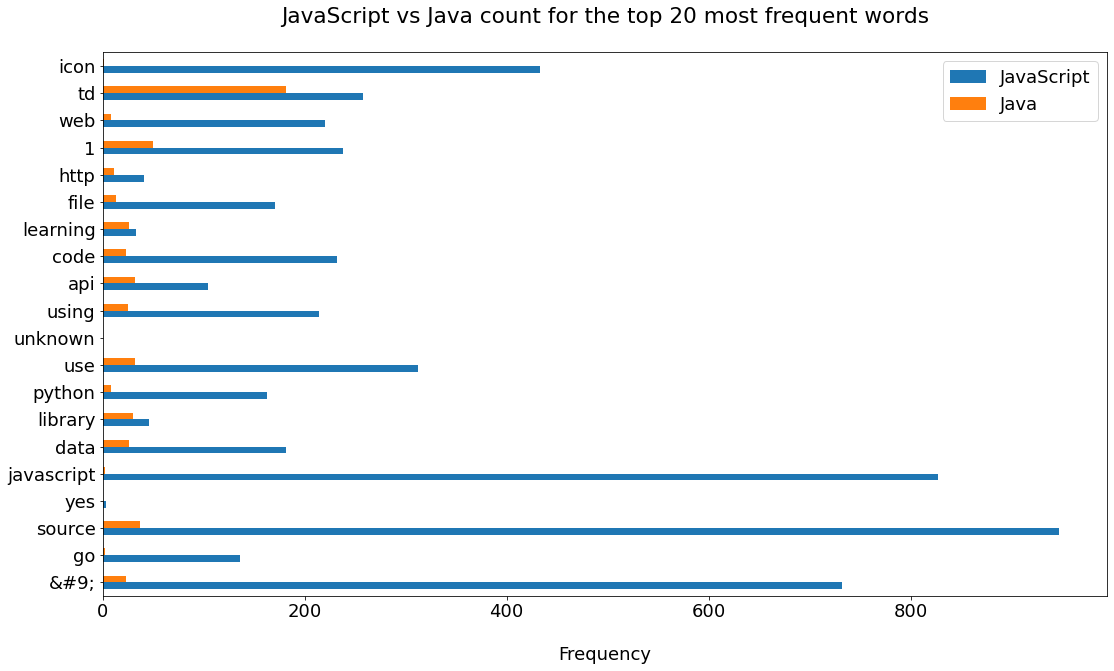

In [51]:
## bar graphing top 20 all words and the frequency they are used in JavaScript and Java

plt.rc('font', size=18)
word_counts.sort_values('all', ascending=False).head(20)[['JavaScript', 
                                                          'Java']].plot.barh(figsize=(18,10))
plt.title('JavaScript vs Java count for the top 20 most frequent words\n')
plt.xlabel('\nFrequency')
None

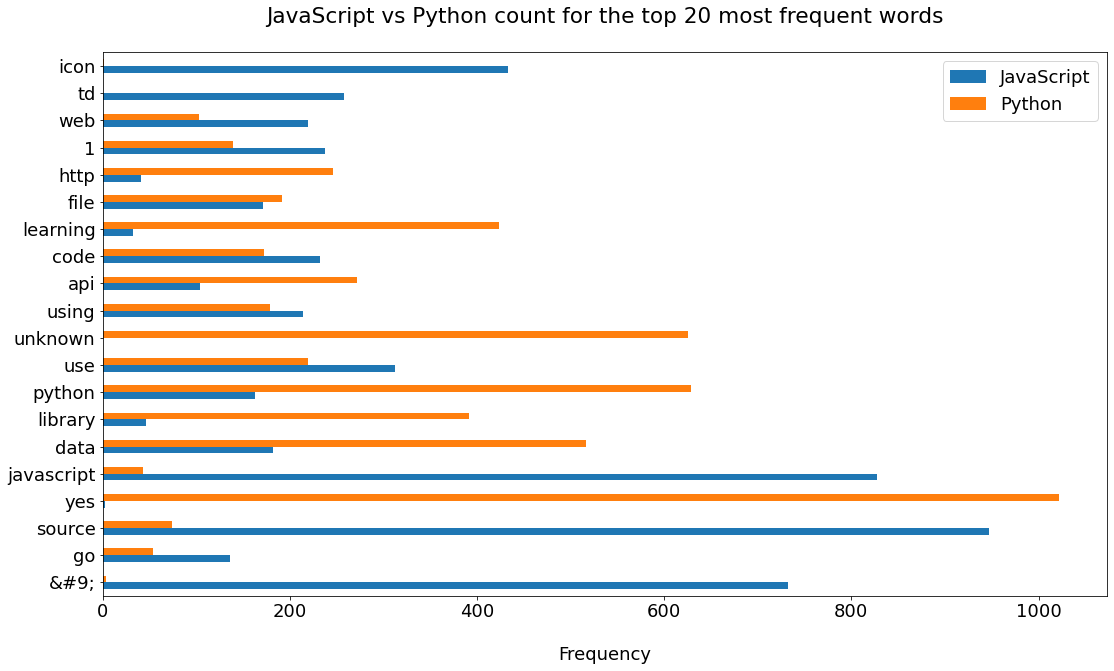

In [52]:
## bar graphing top 20 all words and the frequency they are used in JavaScript and Python

plt.rc('font', size=18)
word_counts.sort_values('all', ascending=False).head(20)[['JavaScript', 
                                                          'Python']].plot.barh(figsize=(18,10))
plt.title('JavaScript vs Python count for the top 20 most frequent words\n')
plt.xlabel('\nFrequency')
None

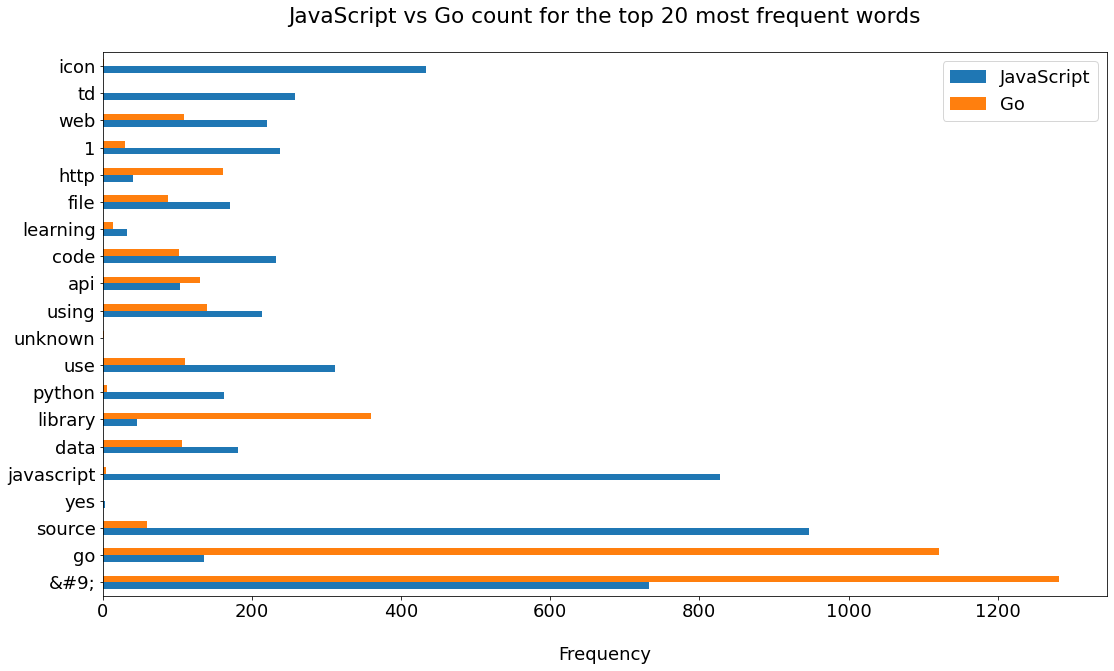

In [53]:
## bar graphing top 20 all words and the frequency they are used in JavaScript and Go

plt.rc('font', size=18)
word_counts.sort_values('all', ascending=False).head(20)[['JavaScript', 
                                                          'Go']].plot.barh(figsize=(18,10))
plt.title('JavaScript vs Go count for the top 20 most frequent words\n')
plt.xlabel('\nFrequency')
None

#### Python Vs Others

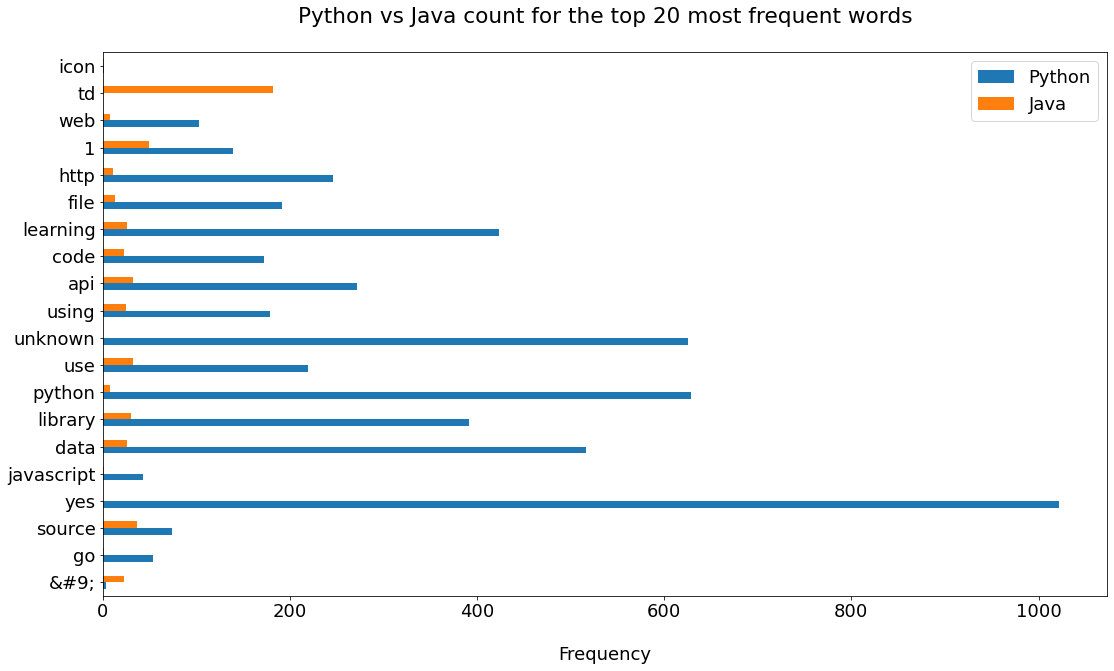

In [55]:
## bar graphing top 20 all words and the frequency they are used in Python and Java

plt.rc('font', size=18)
word_counts.sort_values('all', ascending=False).head(20)[['Python', 
                                                          'Java']].plot.barh(figsize=(18,10))
plt.title('Python vs Java count for the top 20 most frequent words\n')
plt.xlabel('\nFrequency')
None

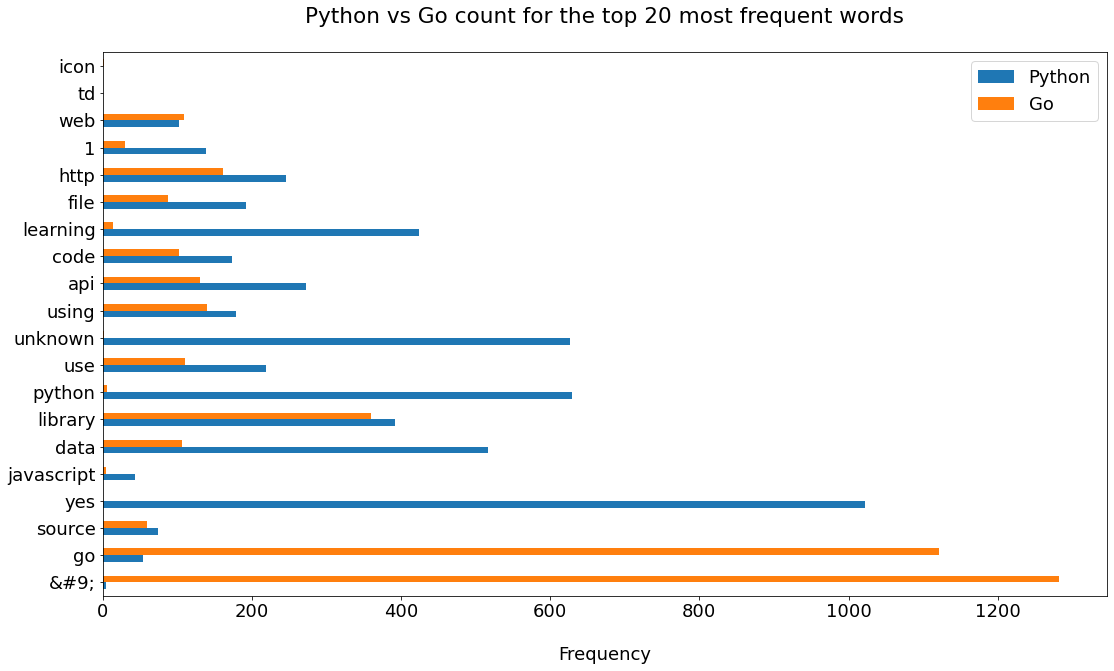

In [56]:
## bar graphing top 20 all words and the frequency they are used in Python and Go

plt.rc('font', size=18)
word_counts.sort_values('all', ascending=False).head(20)[['Python', 
                                                          'Go']].plot.barh(figsize=(18,10))
plt.title('Python vs Go count for the top 20 most frequent words\n')
plt.xlabel('\nFrequency')
None

#### Java Vs Go

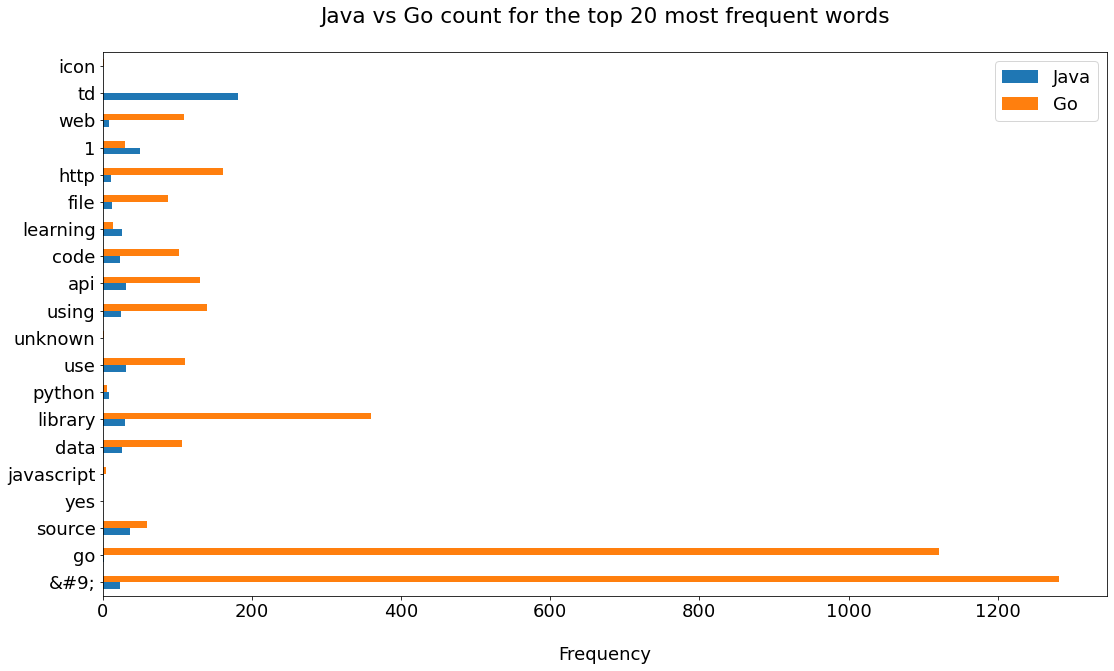

In [57]:
## bar graphing top 20 all words and the frequency they are used in Java and Go

plt.rc('font', size=18)
word_counts.sort_values('all', ascending=False).head(20)[['Java', 
                                                          'Go']].plot.barh(figsize=(18,10))
plt.title('Java vs Go count for the top 20 most frequent words\n')
plt.xlabel('\nFrequency')
None

#### Stacked Bar Charts Overlap By Language

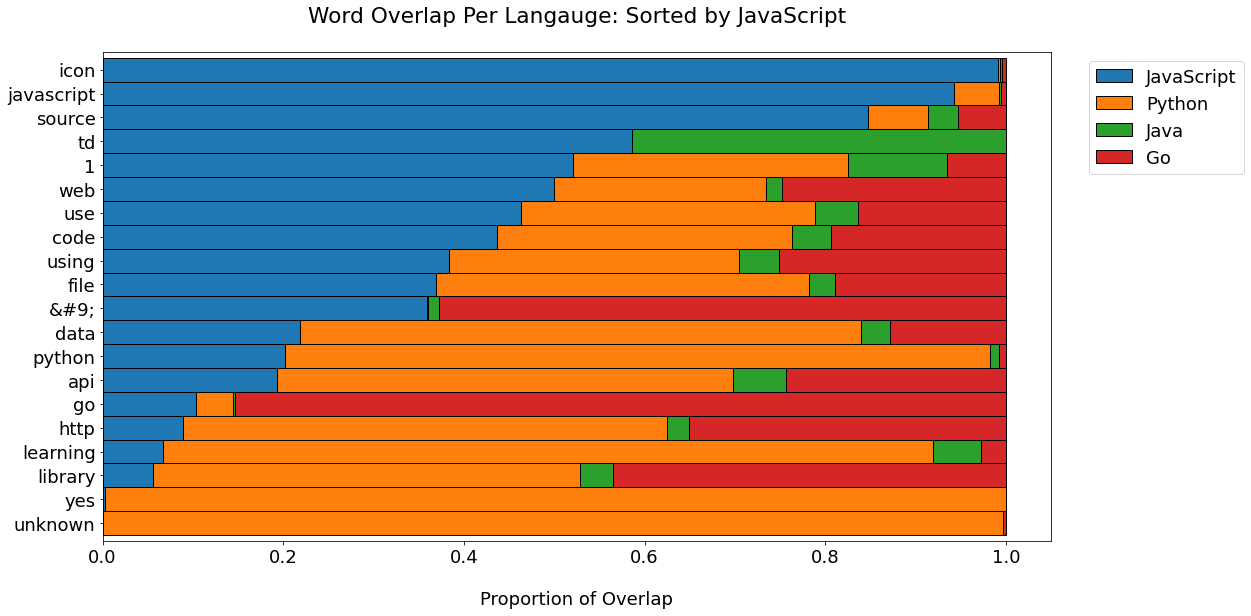

In [59]:
## proportion stacked bar charts sorted by JavaScript

plt.rc('font', size=18)
(word_counts.sort_values(by='all', ascending=False)
 .head(20)
 .apply(lambda row: row / row['all'], axis=1)
 .drop(columns='all')
 .sort_values(by='JavaScript')
 .plot.barh(stacked=True, width=1, ec='black', figsize=(17,9)))
plt.legend(bbox_to_anchor= (1.03, 1))
plt.title('Word Overlap Per Langauge: Sorted by JavaScript\n')
plt.xlabel('\nProportion of Overlap')
plt.show()

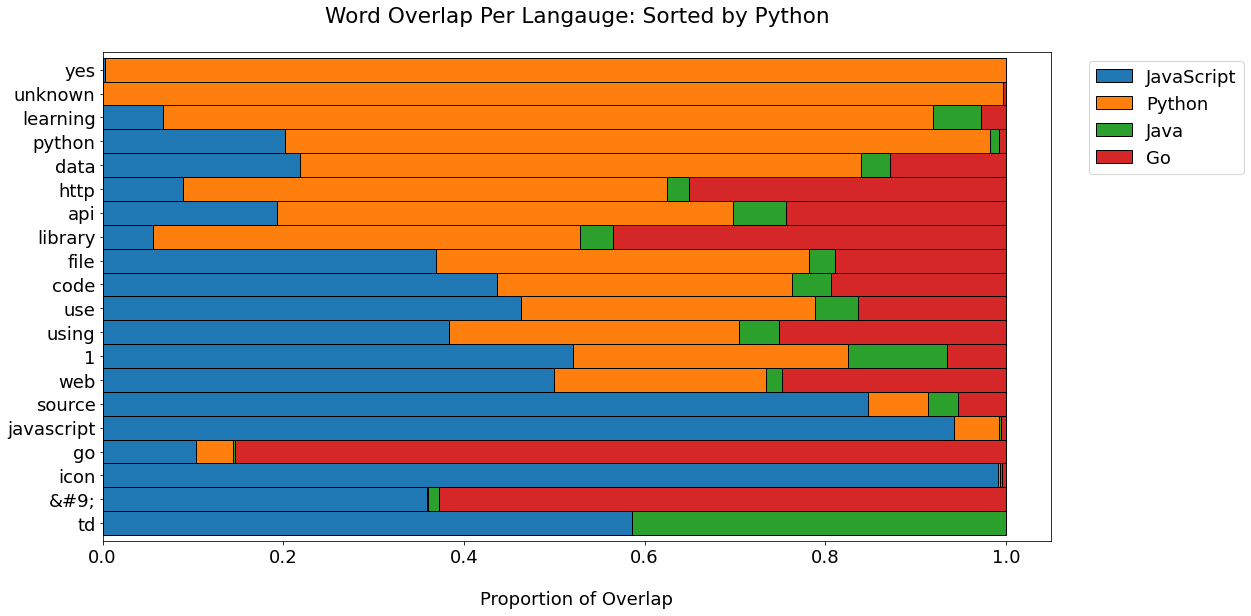

In [60]:
## proportion stacked bar charts sorted by Python

plt.rc('font', size=18)
(word_counts.sort_values(by='all', ascending=False)
 .head(20)
 .apply(lambda row: row / row['all'], axis=1)
 .drop(columns='all')
 .sort_values(by='Python')
 .plot.barh(stacked=True, width=1, ec='black', figsize=(17,9)))
plt.legend(bbox_to_anchor= (1.03, 1))
plt.title('Word Overlap Per Langauge: Sorted by Python\n')
plt.xlabel('\nProportion of Overlap')
plt.show()

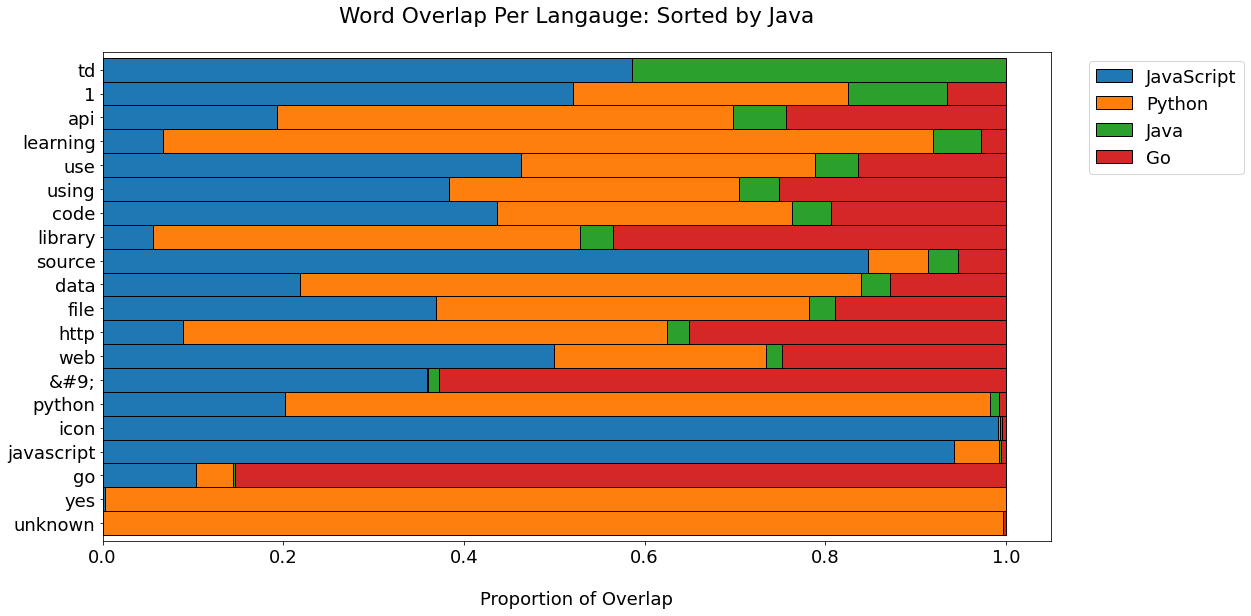

In [61]:
## proportion stacked bar charts sorted by Java

plt.rc('font', size=18)
(word_counts.sort_values(by='all', ascending=False)
 .head(20)
 .apply(lambda row: row / row['all'], axis=1)
 .drop(columns='all')
 .sort_values(by='Java')
 .plot.barh(stacked=True, width=1, ec='black', figsize=(17,9)))
plt.legend(bbox_to_anchor= (1.03, 1))
plt.title('Word Overlap Per Langauge: Sorted by Java\n')
plt.xlabel('\nProportion of Overlap')
plt.show()

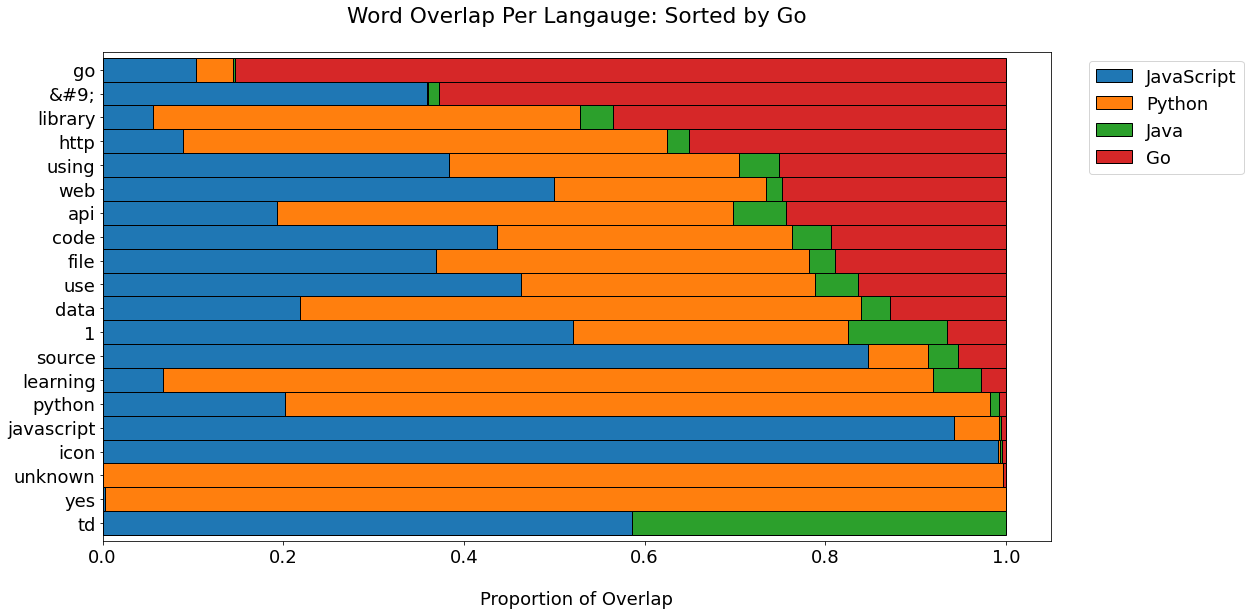

In [62]:
## proportion stacked bar charts sorted by Go

plt.rc('font', size=18)
(word_counts.sort_values(by='all', ascending=False)
 .head(20)
 .apply(lambda row: row / row['all'], axis=1)
 .drop(columns='all')
 .sort_values(by='Go')
 .plot.barh(stacked=True, width=1, ec='black', figsize=(17,9)))
plt.legend(bbox_to_anchor= (1.03, 1))
plt.title('Word Overlap Per Langauge: Sorted by Go\n')
plt.xlabel('\nProportion of Overlap')
plt.show()

#### Bigrams & Trigrams Per Category

##### Bigrams Per Language

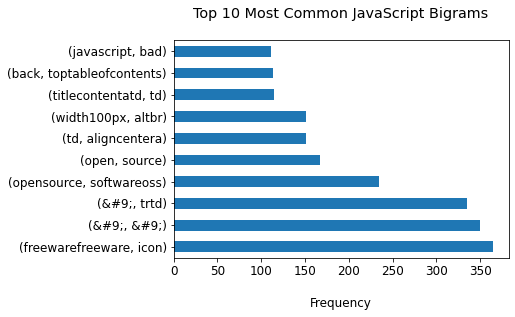

In [77]:
plt.rc('font', size=12)
pd.Series(nltk.bigrams(javascript_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common JavaScript Bigrams\n')
plt.xlabel('\nFrequency')
None

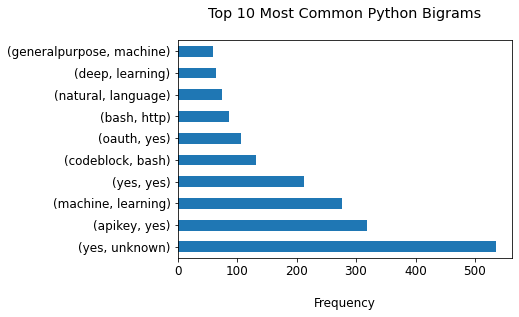

In [76]:
pd.Series(nltk.bigrams(python_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common Python Bigrams\n')
plt.xlabel('\nFrequency')
None

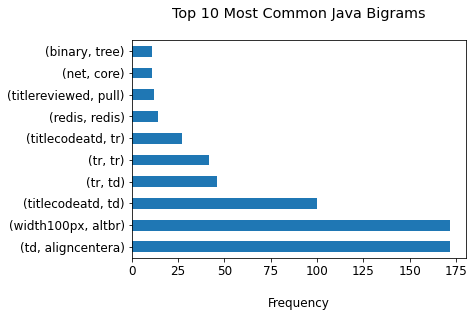

In [75]:
pd.Series(nltk.bigrams(java_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common Java Bigrams\n')
plt.xlabel('\nFrequency')
None

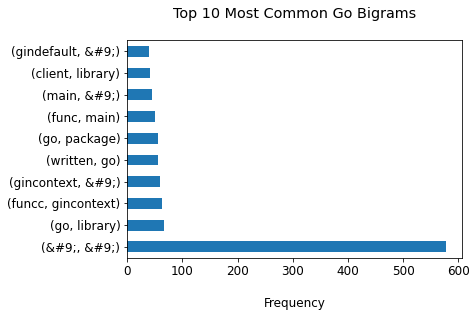

In [74]:
pd.Series(nltk.bigrams(go_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common Go Bigrams\n')
plt.xlabel('\nFrequency')
None

##### All Language Common Bigrams

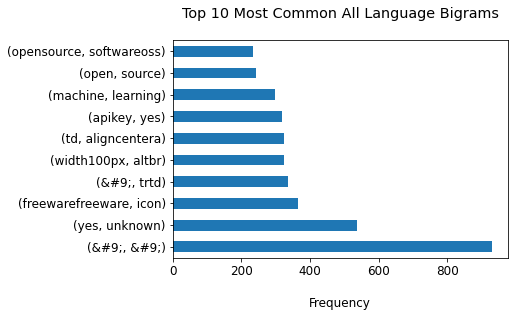

In [73]:
pd.Series(nltk.bigrams(all_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common All Language Bigrams\n')
plt.xlabel('\nFrequency')
None

#### Trigrams

##### Trigrams Per Category

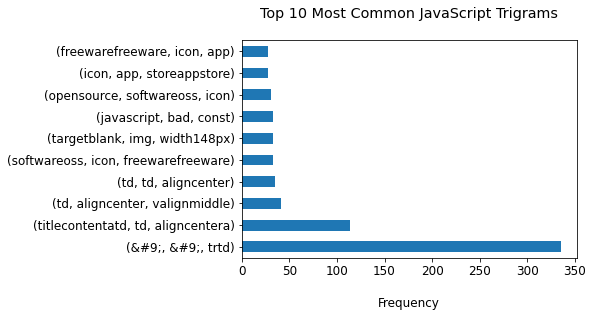

In [78]:
pd.Series(nltk.trigrams(javascript_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common JavaScript Trigrams\n')
plt.xlabel('\nFrequency')
None

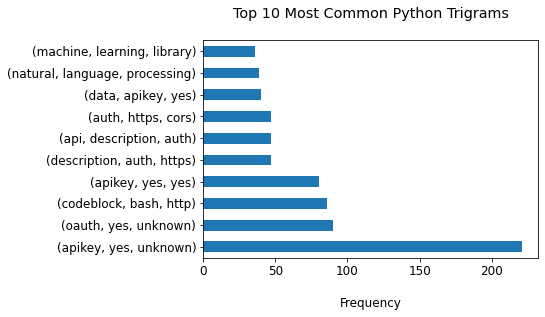

In [79]:
pd.Series(nltk.trigrams(python_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common Python Trigrams\n')
plt.xlabel('\nFrequency')
None

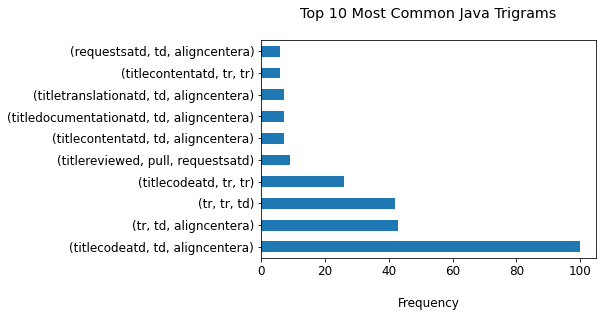

In [80]:
pd.Series(nltk.trigrams(java_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common Java Trigrams\n')
plt.xlabel('\nFrequency')
None

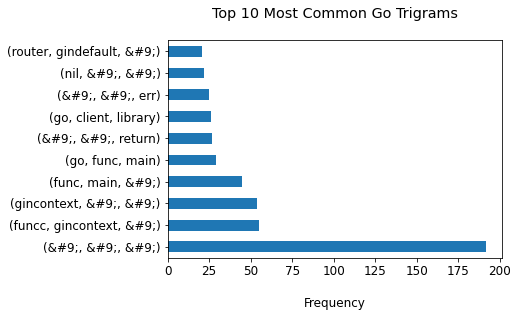

In [81]:
pd.Series(nltk.trigrams(go_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common Go Trigrams\n')
plt.xlabel('\nFrequency')
None

##### Trigrams For All Languages

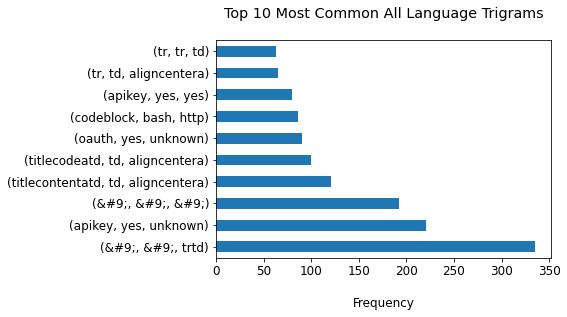

In [82]:
pd.Series(nltk.trigrams(all_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 Most Common All Language Trigrams\n')
plt.xlabel('\nFrequency')
None

#### Wordclouds With Bigrams

In [83]:
## creating a series for the frequencies of the top 20 bigrams of all programming categories

top_20_javascript_bigrams = pd.Series(nltk.bigrams(javascript_words.split()))\
.value_counts().head(20)

top_20_python_bigrams = pd.Series(nltk.bigrams(python_words.split()))\
.value_counts().head(20)

top_20_java_bigrams = pd.Series(nltk.bigrams(java_words.split()))\
.value_counts().head(20)

top_20_go_bigrams = pd.Series(nltk.bigrams(go_words.split()))\
.value_counts().head(20)

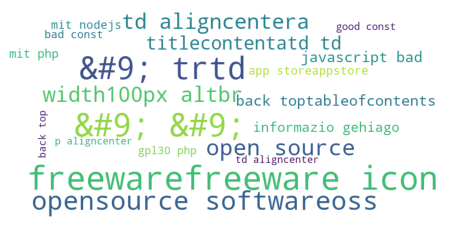

In [84]:
## using list comprehension to creat a dictionary of javascript bigrams as a dictionary
## then making a wordcloud

data = {k[0] + ' ' + k[1]: v for k, v in top_20_javascript_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

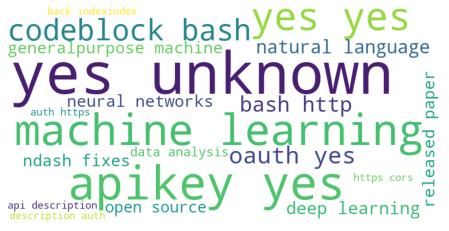

In [85]:
## using list comprehension to creat a dictionary of python bigrams as a dictionary
## then making a wordcloud

data = {k[0] + ' ' + k[1]: v for k, v in top_20_python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

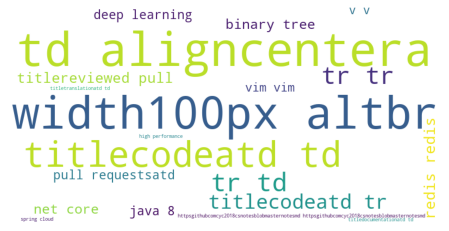

In [86]:
## using list comprehension to creat a dictionary of java bigrams as a dictionary
## then making a wordcloud

data = {k[0] + ' ' + k[1]: v for k, v in top_20_java_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

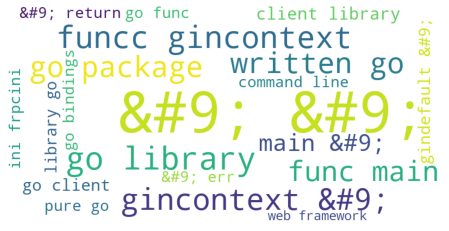

In [87]:
## using list comprehension to creat a dictionary of go bigrams as a dictionary
## then making a wordcloud

data = {k[0] + ' ' + k[1]: v for k, v in top_20_go_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()